# SVM PyTorch with MNIST [0 and 1]
- **Task**: Classification
- **Data**: MNIST Dataset
- **Model**: SVM
- **Loss function**: SVM Loss
- **Optimization**: Stochastic Gradient Descent

In [1]:
!pip install -q watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00


In [2]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.3.0+cu121



## 1. Import Library

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

### 2.1. MNIST Dataset

In [3]:
# Loading training data
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                               ]),
                               download=True)
# Loading test data
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                              ]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 45609957.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1637588.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13299791.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8225616.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 2.2. Data Information

In [4]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 60000
Number of testing samples: 10000


In [5]:
print(f"Datatype of the 1st training sample: {train_dataset[0][0].type()}")
print(f"Size of the 1st training sample: {train_dataset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([1, 28, 28])


### 2.3. Data Visualization

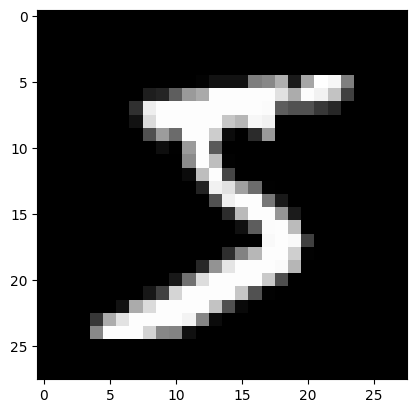

In [6]:
img_5 = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img_5, cmap='gray')
plt.show()

### 2.4. Load Dataset into DataLoader

In [49]:
from torch.utils.data import DataLoader

# Load train and test data samples into dataloader
batch_size = 64

# Only select all samples with labels is 0 and 1
train_indices = ((train_dataset.targets == 0) + (train_dataset.targets == 1)).nonzero().view(-1)
test_indices = ((test_dataset.targets == 0) + (test_dataset.targets == 1)).nonzero().view(-1)
train_dataset.targets[train_dataset.targets == 0] = -1
train_dataset.targets[train_dataset.targets == 1] = 1
test_dataset.targets[test_dataset.targets == 0] = -1
test_dataset.targets[test_dataset.targets == 1] = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices))

In [50]:
print(f"Number of training samples: {len(train_loader)}")
print(f"Number of testing samples: {len(test_loader)}")

Number of training samples: 106
Number of testing samples: 18


## 3. Model

In [51]:
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [52]:
INPUT_DIM = 28*28 # makes a 1D vector of 784

In [53]:
model = SVM(input_dim=INPUT_DIM)

## 4. Loss Function and Optimization

In [54]:
LR = 0.001
EPOCHS = 50

In [55]:
class SVMLoss(nn.modules.Module):
    def __init__(self):
        super(SVMLoss,self).__init__()
    def forward(self, outputs, labels):
         return torch.sum(torch.clamp(1 - outputs.t()*labels, min=0))/batch_size

In [56]:
criterion = SVMLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## 5. Train

In [57]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(data.size(0), -1).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(data.size(0), -1).to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.sign()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

Train Epoch: 1 [0/60000]	Loss: 1.289393
Train Epoch: 1 [6400/60000]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 2 [0/60000]	Loss: 0.000000
Train Epoch: 2 [6400/60000]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 3 [0/60000]	Loss: 0.000000
Train Epoch: 3 [6400/60000]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 4 [0/60000]	Loss: 0.000000
Train Epoch: 4 [6400/60000]	Loss: 0.000882

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 5 [0/60000]	Loss: 0.000000
Train Epoch: 5 [6400/60000]	Loss: 0.004925

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 6 [0/60000]	Loss: 0.000000
Train Epoch: 6 [6400/60000]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 1135/10000 (11.35%)

Train Epoch: 7 [0/60000]	Loss: 0.000000
Train Epoch: 7 [6400/60000]	Loss: 0.000000

Test set: Average loss: 0.0000, Ac

## 6. Conclusion
- **Accuracy**: 11.35% with two labels 0 and 1